In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from scipy import sparse

import mlrfit as mf
import lrrouting as ldr

import cvxpy as cp

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 10

mtype = "small_world"
n = 5000
# G = nx.connected_watts_strogatz_graph(n, k=4, p=0.1)
# G.remove_edges_from(nx.selfloop_edges(G))
# G = nx.DiGraph(G)

beta = 0.8
gamma = 0.01
G = nx.scale_free_graph(n, alpha=1-beta-gamma, beta=beta, gamma=gamma)#alpha=0.41, beta=0.54)

n = G.number_of_nodes()
print(f"{n=}, {G.number_of_edges()=}")

# for u, v in G.edges():
#     G[u][v]['weight'] = np.random.rand() * 10

Adj, Dist, nodes_cc = ldr.nx_graph_to_matrices(G, nodes=True)
G = G.subgraph(nodes_cc)
n = G.number_of_nodes()
A = Dist

n=5000, G.number_of_edges()=25066
[495, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

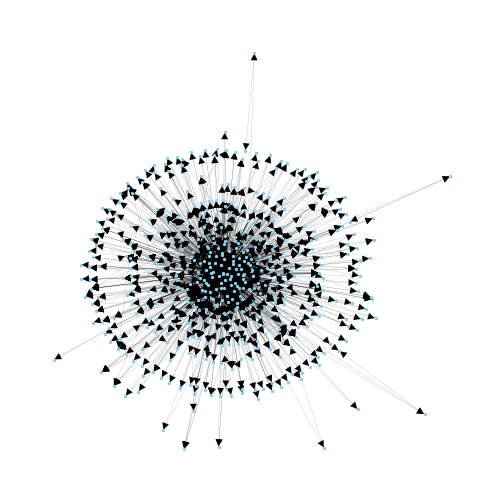

In [4]:
ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
assert nx.is_strongly_connected(G)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([6.69931640e-02, 2.90792933e-01, 2.41623696e-02, 2.60256018e-03,
        6.43576401e-05]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. ]))

In [6]:
adjacency_list = ldr.adjacency_directed_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

In [7]:
PSD = False
w_min = A[A>0].min()
rt_max_iters = min(int(5*A.max()/w_min), (10**4) // 2)
symm = np.allclose(A, A.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=False


In [8]:
np.histogram(Adj[Adj>0], bins=5, density=True)

(array([9.84794279e-03, 1.43486296e-05, 0.00000000e+00, 1.43486296e-05,
        4.78287654e-06]),
 array([  1. , 102.2, 203.4, 304.6, 405.8, 507. ]))

In [9]:
info = {} 

In [10]:
fraction_of_nodes = 0.5
pi_rows = np.random.permutation(n)[:int(n * fraction_of_nodes)]
pi_cols = np.random.permutation(n)[:int(n * fraction_of_nodes)]

pi_row_Dist = ldr.sparse_sampled_matrix(pi_rows, Dist, rows=True)
pi_col_Dist = ldr.sparse_sampled_matrix(pi_cols, Dist, rows=False)



rDist = np.zeros((n, n))
rDist[pi_rows] = Dist[pi_rows]
assert np.allclose(pi_row_Dist.toarray(), rDist)

cDist = np.zeros((n, n))
cDist[:, pi_cols] = Dist[:, pi_cols]
assert np.allclose(pi_col_Dist.toarray(), cDist.T)
print("PASSED")

rDist = Dist[pi_rows]
cDist = Dist[:, pi_cols].T

PASSED


In [11]:
L2 = np.zeros((n, n))
L, L_inv = ldr.simple_laplacian_from_pi(pi_rows, n, debug=True)

for i in pi_rows:
    for j in range(n):
        if j == i or L2[i, j] == -1: continue
        L2[i, i] += 1
        L2[j, j] += 1
        L2[i, j] = -1
        L2[j, i] = -1

assert (np.allclose(L2, L)) and (np.allclose(np.linalg.norm(L.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(L2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L2.sum(axis=1)), 0))
# print(L2,"\n\n",  L)
print("PASSED")

PASSED


In [12]:
L = ldr.laplacian_from_row_col_pi(pi_rows, pi_cols, n, debug=False)

L2 = np.zeros((2*n, 2*n))

for i in pi_rows:
    for j in range(n):
        L2[i, i] += 1
        L2[n+j, n+j] += 1
        L2[i, n+j] = -1
        L2[n+j, i] = -1

for j in pi_cols:
    for i in range(n):
        if L2[i, n+j] == -1: continue
        L2[i, i] += 1
        L2[n+j, n+j] += 1
        L2[i, n+j] = -1
        L2[n+j, i] = -1


assert (np.allclose(L2, L)) and (np.allclose(np.linalg.norm(L.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(L2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L2.sum(axis=1)), 0))
# print(L2,"\n\n",  L)
print("PASSED")

PASSED


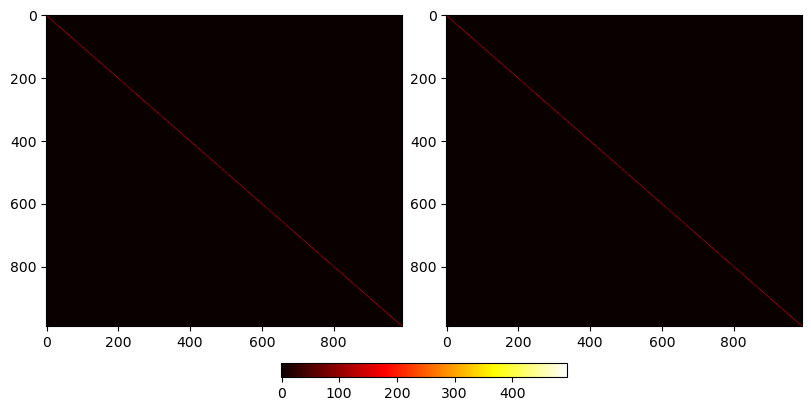

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

im1 = axs[0].imshow(L, aspect='auto', cmap='hot')
im2 = axs[1].imshow(L2, aspect='auto', cmap='hot')

fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04, )

In [15]:
X = np.random.randn(100, 20)
Gram = X @ X.T 
d1 = np.diag(Gram)
d2 = np.einsum('ik,ik->i', X, X)
assert np.allclose(d1, d2)
Y = np.random.randn(X.shape[0], X.shape[1])

D1 = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    for j in range(Y.shape[0]):
        D1[i, j] = np.sqrt(np.square(X[i] - Y[j]).sum())
D2 = ldr.asymm_eulidean_dist_matrix(X, Y)
assert np.allclose(D2, D1), mf.rel_diff(D2, D1)

print("PASSED")

PASSED


In [16]:
Z_emb, loss = ldr.slow_cc(rank, pi_rows, pi_cols, rDist, cDist, n_init=10, max_iter=1000, eps=1e-6, freq=300, verbose=True, debug=True)[:2]

t=0, loss=4.4151061309903215
t=300, loss=0.19104168368875835
t=600, loss=0.17849335833829097
t=900, loss=0.17665043230144645
loss=0.17632956294507263
t=0, loss=4.5143339431592375
t=300, loss=0.20215197114144415
t=600, loss=0.19062340458857824
t=900, loss=0.18445401131921899
loss=0.1832897659399585
t=0, loss=4.406999424348528
t=300, loss=0.204913081390696
t=600, loss=0.18467187110796462
t=900, loss=0.17708258187595705
loss=0.17590747475475332
t=0, loss=4.479096928384692
t=300, loss=0.19821516030842765
t=600, loss=0.18073761036769215
t=900, loss=0.1756579504336015
loss=0.17461991659782516
t=0, loss=4.612579296583004
t=300, loss=0.2033755660657612
t=600, loss=0.18114678978540677
t=900, loss=0.17392377206145926
loss=0.17275985594195595
t=0, loss=4.4856250839035985
t=300, loss=0.20325017576016094
t=600, loss=0.19050904989367337
t=900, loss=0.17783101031412799
loss=0.17349766118425752
t=0, loss=4.670945295263813
t=300, loss=0.20436857250817672
t=600, loss=0.18498512441508538
t=900, loss=0.17

In [17]:
l_dar = ldr.construct_xy_node_embedding_graph(Z_emb[:n], Z_emb[n:], adjacency_list)
_ = {'ratios' : ldr.subopt_ratios(l_dar, Dist, sources, targets)}

median_stretch=100.0%, mean_stretch=272.6%
%[ratio<2] = 74.20%, %[ratio<1.2] = 64.50%, %[ratio=1.] = 63.60%


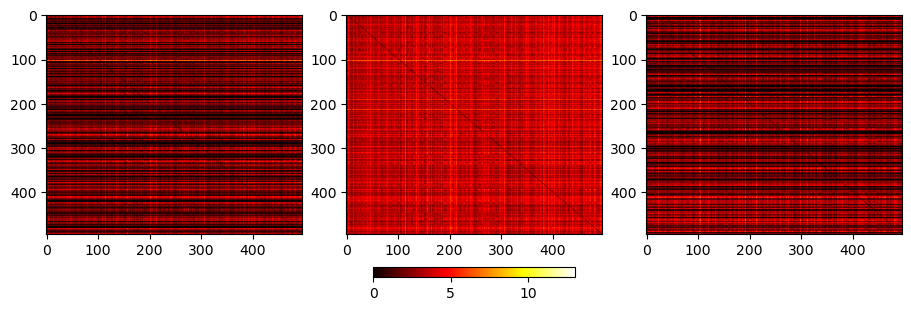

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im1 = axs[0].imshow(pi_row_Dist.toarray(), aspect='auto', cmap='hot')
im2 = axs[1].imshow(Dist, aspect='auto', cmap='hot')
im3 = axs[2].imshow(pi_col_Dist.toarray(), aspect='auto', cmap='hot')

fig.colorbar(im1, ax=axs, orientation='horizontal', fraction=0.046, pad=0.04, )